# Companies Dataset Analysis
*All* analysis that was done on this dataset is in companies_scratchpad.ipynb. This is a summary of the highlights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('companies_dataset_nounits.csv')
print(raw_data.head())

  company       company_type    year  quarter  quarterly_revenue_mil  \
0    Visa  payment_processor  2010.0      3.0                 1710.0   
1    Visa  payment_processor  2010.0      4.0                 1740.0   
2    Visa  payment_processor  2010.0      1.0                 1650.0   
3    Visa  payment_processor  2010.0      2.0                 1650.0   
4    Visa  payment_processor  2010.0      3.0                 1880.0   

   quarterly_revenue  gross_profit_mil  gross_profit  gross_margin  users_mil  \
0       1.710000e+09            1300.0  1.300000e+09         0.760     1670.0   
1       1.740000e+09            1350.0  1.350000e+09         0.775     1720.0   
2       1.650000e+09            1260.0  1.260000e+09         0.767     1720.0   
3       1.650000e+09            1270.0  1.270000e+09         0.770     1730.0   
4       1.880000e+09            1410.0  1.410000e+09         0.752     1770.0   

          users user_type  revenue_per_user        term_1  \
0  1.670000e+09    

## Plan
1. perform nonlinear regression on each company in this dataset
       * fitting to the Universal Scalability Law
       * USL information found here: https://cdn2.hubspot.net/hubfs/498921/eBooks/scalability_new.pdf
       * nonlinear least-squares regression plan on pg. 18
2. Use mixture model to classify companies

## The Universal Scalability Law
The universal scalability law is essentially Amdahl's Law w/ an additional term to account for communication costs. 

Here it is

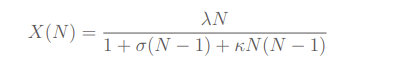

Here's the mapping onto a company:

N    (ie. parallelization) <=> number of users

X(N) (ie. throughput)      <=> revenue 

The lambda, sigma, and kappa coefficients are what we're trying to find using nonlinear regression

In [3]:
# let's first separate the companies from each other
companies = raw_data['company'].unique()
company_data = {}
for company in companies:
    company_data[company] = raw_data[raw_data['company'] == company]

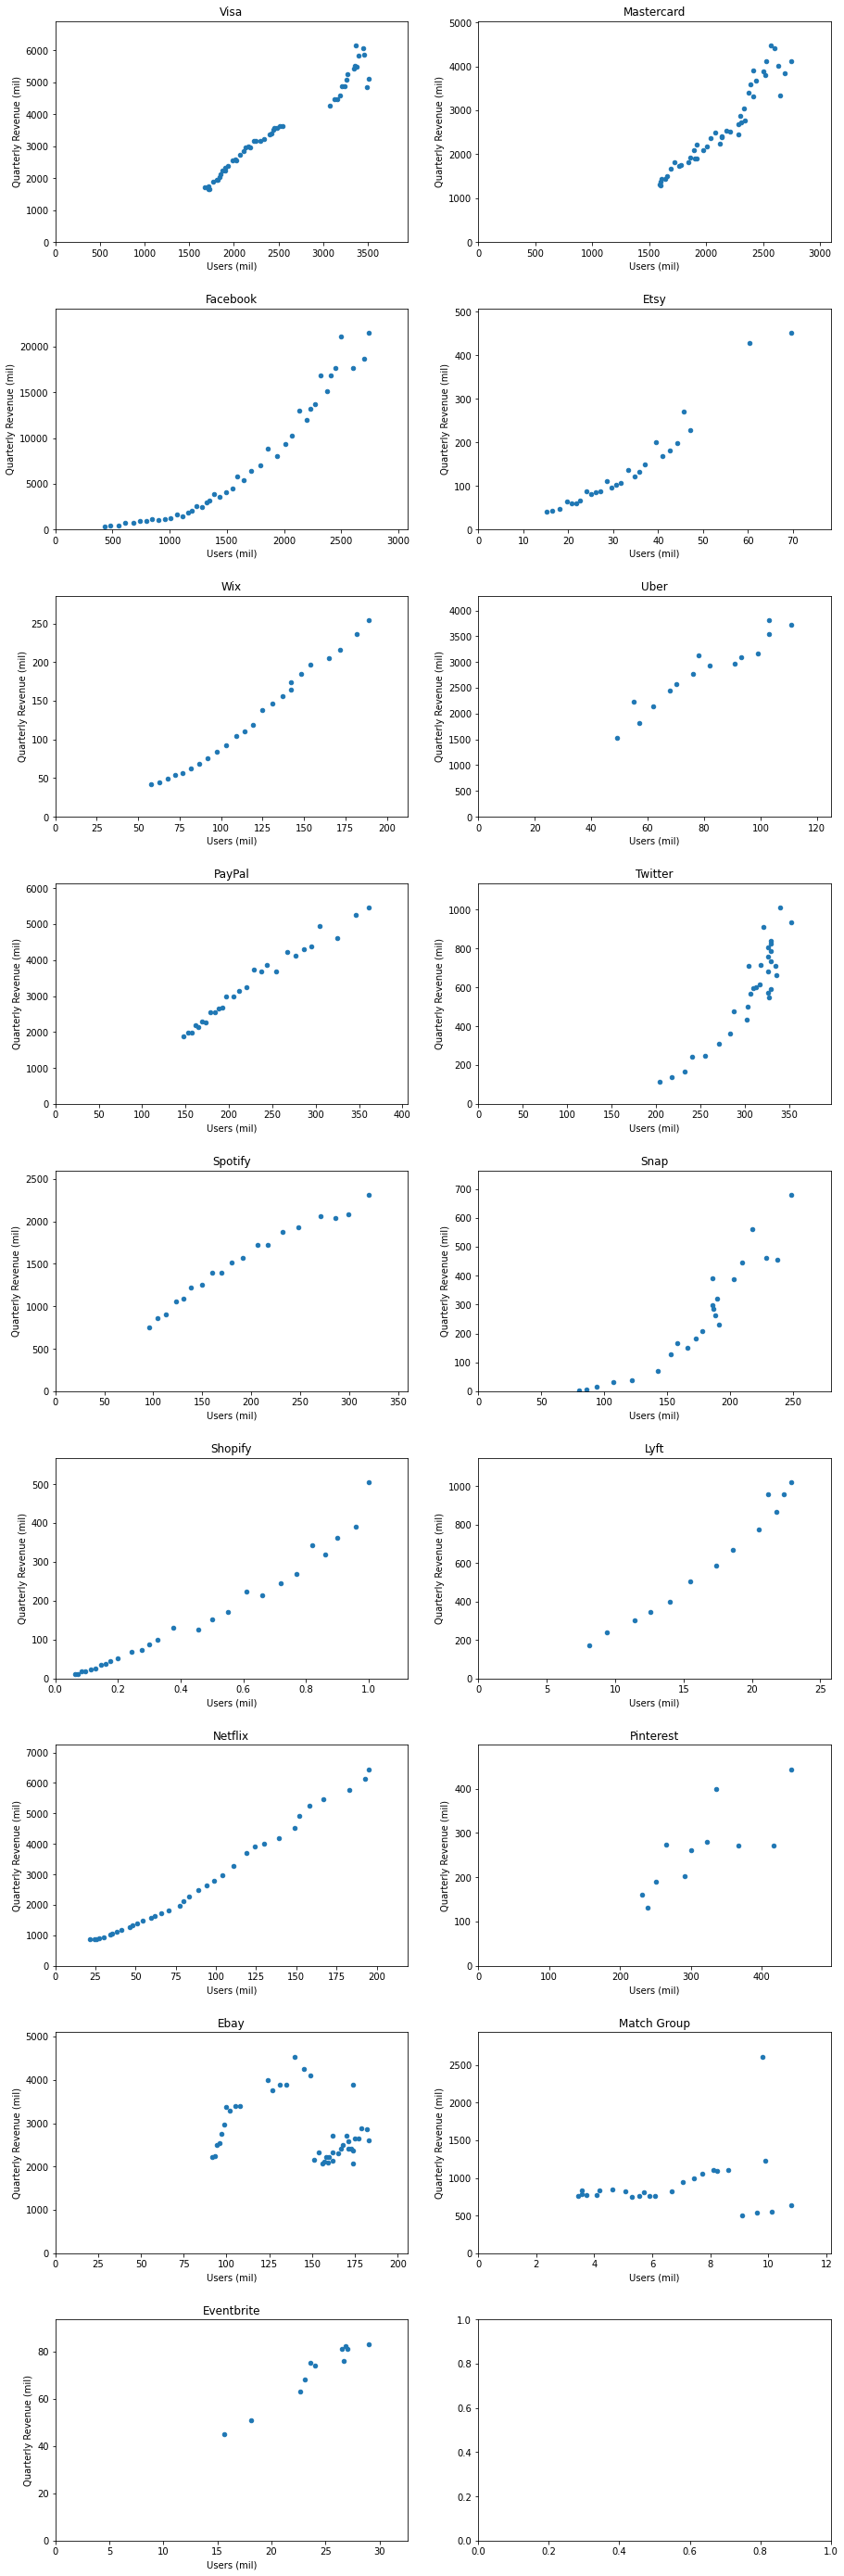

In [4]:
# the USL is a general "law" that can apply to any system - here the company is the system
# the "throughput" of the company is the revenue
# the "nodes" of the company are the users/customers (this isn't immediately obvious)

# so let's graph nodes vs. throughput
# all companies user vs. revenue graphs

fig, axs = plt.subplots(9, 2, figsize=(15,50))
for i, c in enumerate(companies):
    # cplt = user_rev_fig.add_subplot(1, 1, 1)
    spxi = int(np.floor(i/2))
    spyi = i % 2
    company_data[c].plot(
        kind='scatter',
        x='users_mil',
        y='quarterly_revenue_mil',
        ax=axs[spxi, spyi],
        xlabel='Users (mil)',
        ylabel='Quarterly Revenue (mil)',
        title=c,
    )
    xmax = company_data[c]['users_mil'].max()
    ymax = company_data[c]['quarterly_revenue_mil'].max()
    axs[spxi, spyi].set_xlim(0, xmax + xmax/8)
    axs[spxi, spyi].set_ylim(0, ymax + ymax/8)
plt.subplots_adjust(hspace=0.3)
plt.show()

Nonlinear least-squares regression: https://en.wikipedia.org/wiki/Non-linear_least_squares

Leads me to the Gauss-Newton algorithm: https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm

So that's what we'll attempt to implement

To carry out the steps:

1. We start with an initial guess for the parameters, lambda, sigma, and kappa

2. We need the jacobian matrix, which requires the gradient of the USL

3. We need to calculate the residuals of our data

4. Then carry out the nls regression, updating the parameters beta at each step - we stop when we've reached a convergence criterion

## Universal Scalability Law Equation
R(u) = (lambda * u) / (1 + sigma * (u-1) + kappa * u * (u-1))
## Gradients
we have to solve for the partial derivative of the residual w/ respect to each parameter

residual function is Y - usl(X, lambda, sigma, kappa)

dr / dlambda = u / (1 + sigma * (u-1) + kappa * u * (u-1))

dr / dsigma  = (lambda * u * (u-1)) / (1 + sigma * (u-1) + kappa * u * (u-1))^2

dr / dkappa  = (lambda * u^2 * (u-1)) / (1 + sigma * (u-1) + kappa * u * (u-1))^2

In [5]:
'''
u - # users (x-value)
beta - model params - (3,1) shape - (lmda, sigma, kappa)
'''
def dr_dlambda (u, beta):
    return u / (1 + beta[1]*(u-1) * beta[2]*u*(u-1))
def dr_dsigma (u, beta):
    return (beta[0] * u * (u-1)) / (1 + beta[1]*(u-1) + beta[2]*u*(u-1))**2
def dr_dkappa (u, beta):
    return (beta[0] * (u**2) * (u-1)) / (1 + beta[1]*(u-1) + beta[2]*u*(u-1))**2

def usl (u, beta):
    return (beta[0] * u) / (1 + beta[1]*(u-1) * beta[2]*u*(u-1))

In [6]:
def usl_nls_regression(x, y, beta0, gradient):
    '''
    x - x values - shape (?, 1)
    y - y values - shape (?, 1)
    beta0 - initial parameter values - (lambda, sigma, kappa)
    gradient - model's gradient matrix - shape (3,1)
    '''
    assert len(x) > len(beta0)
    assert beta0.shape == gradient.shape
    
    # initialize jacobian
    Jacobian = np.zeros((len(x), len(beta0)))
    
    # the parameter vector
    beta = beta0
    print('beta0', beta)
    
    num_iterations = 0
    
    # iterate
    while True:
        beta_prev = beta
        
        Jacobian[:, 0] = gradient[0](x, beta)
        Jacobian[:, 1] = gradient[1](x, beta)
        Jacobian[:, 2] = gradient[2](x, beta)
        
        residuals = y - usl(x, beta)
        
        temp1 = np.linalg.inv(np.dot(Jacobian.T, Jacobian))
        temp2 = np.dot(temp1, Jacobian.T)
        update_var = np.dot(temp2, residuals)
        
        beta = beta - update_var
        #fix lambda:
        # beta[0] = beta0[0]
        
        num_iterations += 1
        
        # we'll stop after 200 iterations
        if num_iterations % 300 == 0:
            print('iterations: ', num_iterations)
            print('update_var: ', update_var)
            print('beta: ', beta)
            break
        
        # convergence criterion
        if (max(abs(beta_prev - beta))) <= 0.000001:
            break

    
    return beta

visa_initial_lmda  = company_data['Visa']['revenue_per_user'][0]
visa_initial_sigma = company_data['Visa']['gross_margin_density'][0]
visa_initial_kappa = company_data['Visa']['gmd_coef'][0]
visa_initial = np.array([visa_initial_lmda, visa_initial_sigma, visa_initial_kappa])

usl_gradients = np.array([dr_dlambda, dr_dsigma, dr_dkappa])

visa_users = np.array(company_data['Visa']['users_mil'])
visa_rev   = np.array(company_data['Visa']['quarterly_revenue_mil'])

In [7]:
params = usl_nls_regression(visa_users, visa_rev, visa_initial, usl_gradients)

# fix beta param b/c of exploding gradients
# the intuition is that the revenue / user metric is the lambda param,
# so here we just fix that param
params[0] = visa_initial[0]

beta0 [ 1.02e+00  4.54e-10 -3.88e-10]
iterations:  300
update_var:  [-1.00687271e+90 -6.77626358e-17  6.08804931e-21]
beta:  [ 2.01374541e+90 -8.82118449e-04  4.52086924e-09]


In [8]:
# looks like an exploding gradient w/ respect to lambda. 
# I tried graphing this, and it looks *okay*, but it doesn't work

def print_params(beta):
    print('lambda: ', beta[0])
    print('sigma: ', beta[1])
    print('kappa: ', beta[2])
    
def data_model_plot(company_name, params):
    users = company_data[company_name]['users_mil']
    quarterly_rev = company_data[company_name]['quarterly_revenue_mil']

    # plot datapoints
    x_edgebuffer = users.max()*0.1
    y_edgebuffer = quarterly_rev.max()*0.1
    plt.scatter(x=users, y=quarterly_rev)
    plt.xlim(0, users.max() + x_edgebuffer)
    plt.ylim(0, quarterly_rev.max() + y_edgebuffer)
    plt.title(company_name)
    plt.xlabel('Users (mil)')
    plt.ylabel('Quarterly Revenue (mil)')

    # plot USL w/ params from regression
    usl_x = np.linspace(0, 4000, num=100)
    usl_y = usl(usl_x, params)
    plt.plot(usl_x, usl_y, 'r--')
    plt.show()
    
    print_params(params)

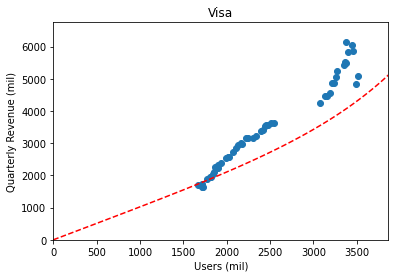

lambda:  1.02
sigma:  -0.0008821184485506437
kappa:  4.520869238805904e-09


In [9]:
data_model_plot('Visa', params)

Visa
beta0 [ 1.02e+00  4.54e-10 -3.88e-10]
iterations:  300
update_var:  [-1.00687271e+90 -6.77626358e-17  6.08804931e-21]
beta:  [ 2.01374541e+90 -8.82118449e-04  4.52086924e-09]


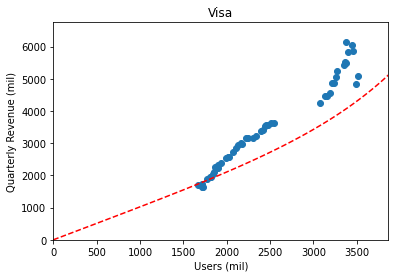

lambda:  1.02
sigma:  -0.0008821184485506437
kappa:  4.520869238805904e-09
Mastercard
beta0 [ 8.10e-01  2.25e-10 -1.69e-10]
iterations:  300
update_var:  [-4.61224405e+90  3.52180583e-18 -1.31153606e-21]
beta:  [ 9.22448812e+90 -3.98294353e-03  2.08913347e-06]


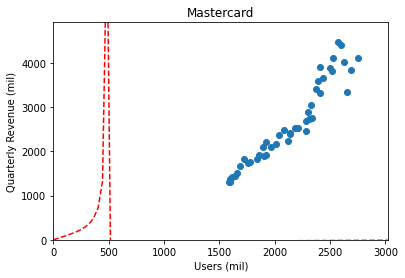

lambda:  0.81
sigma:  -0.003982943534785842
kappa:  2.0891334719776717e-06
Facebook
beta0 [ 8.00e-01  1.65e-09 -1.43e-09]
iterations:  300
update_var:  [ 1.82861925e+97  1.61071785e-17 -1.22925656e-19]
beta:  [-3.65723850e+97 -1.26093871e+00  5.54096593e-03]


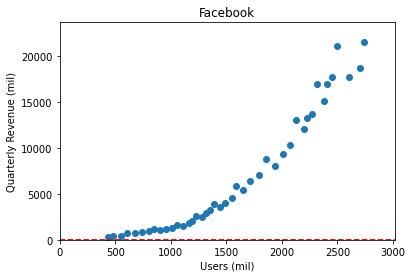

lambda:  0.8
sigma:  -1.2609387053787022
kappa:  0.005540965933469342
Etsy
beta0 [ 2.69e+00  4.00e-08 -1.68e-08]
iterations:  300
update_var:  [-2.38004743e+90 -1.51788304e-18  7.96210970e-20]
beta:  [ 4.76009486e+90 -4.07416251e-02  7.04657934e-05]


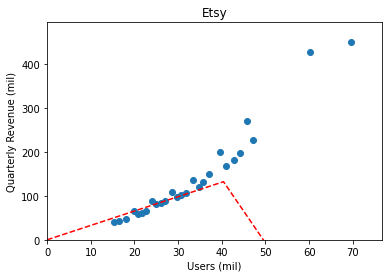

lambda:  2.69
sigma:  -0.04074162506062839
kappa:  7.046579335916402e-05
Wix
beta0 [ 7.20e-01  1.40e-08 -1.23e-08]
iterations:  300
update_var:  [-7.31520168e+89  1.68051337e-18 -5.50571416e-20]
beta:  [ 1.46304034e+90 -1.49194679e-02  1.80554055e-05]


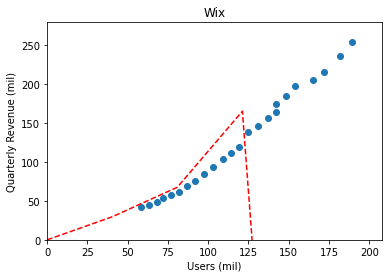

lambda:  0.72
sigma:  -0.014919467928504534
kappa:  1.8055405452601705e-05
Uber
beta0 [ 3.10e+01  9.46e-09 -4.25e-04]
iterations:  300
update_var:  [-2.92304360e+92  4.55193814e-12 -1.23312307e-13]
beta:  [ 5.82713469e+92 -8.68882009e-02  1.34822944e-03]


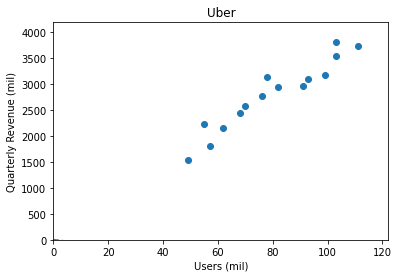

lambda:  31.0
sigma:  -0.0868882009296042
kappa:  0.0013482294439038395
PayPal
beta0 [1.26e+01 3.51e-09 5.67e-09]
iterations:  300
update_var:  [-1.04306467e+91  2.99104274e-17 -1.02120410e-19]
beta:  [ 2.08612935e+91 -6.30035975e-03  1.10242316e-05]


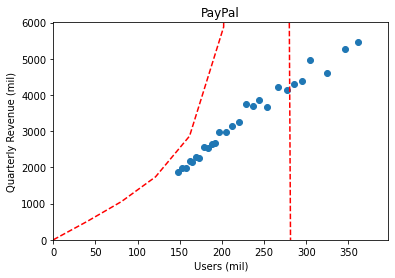

lambda:  12.6
sigma:  -0.006300359749943491
kappa:  1.1024231602908547e-05
Twitter
beta0 [ 0.56     0.00314 -0.00182]
iterations:  300
update_var:  [-1.15914596e+112  2.21888751e-017 -8.75074370e-020]
beta:  [ 2.31829193e+112  6.32570083e+008 -2.10179056e+006]


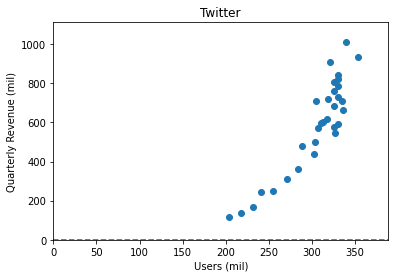

lambda:  0.56
sigma:  632570083.4110819
kappa:  -2101790.5551822986
Spotify
beta0 [7.80e+00 5.22e-10 8.64e-09]
iterations:  300
update_var:  [-2.27255896e+90 -4.33680869e-19  7.19978005e-21]
beta:  [ 4.54511791e+90 -7.37312487e-03  1.52569993e-05]


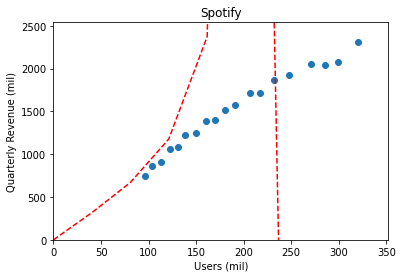

lambda:  7.8
sigma:  -0.0073731248678855586
kappa:  1.5256999250691292e-05
Snap
beta0 [ 5.00e-02 -5.45e-08  5.46e-08]
iterations:  300
update_var:  [-1.22053877e+97 -3.46436475e-19 -6.42884772e-21]
beta:  [ 2.44107754e+97 -7.13746882e+01  4.61253336e-01]


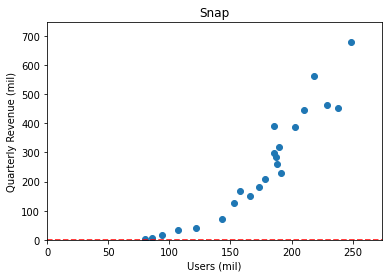

lambda:  0.05
sigma:  -71.37468815940262
kappa:  0.4612533356016379
Shopify
beta0 [1.70e+02 1.30e-05 3.74e-04]
iterations:  300
update_var:  [ 3.01022773e+92 -1.28230759e-14 -4.99600361e-15]
beta:  [-6.02045546e+92  2.63214144e+00  2.46653148e+00]


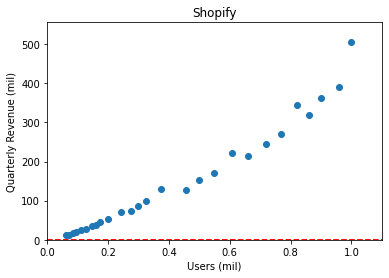

lambda:  170.0
sigma:  2.6321414369188427
kappa:  2.4665314839566226
Lyft
beta0 [ 5.00e-02  3.85e-08 -3.78e-08]
iterations:  300
update_var:  [-2.15959056e+102  3.40331062e-016 -1.04286696e-017]
beta:  [ 4.31918112e+102 -8.41886939e+004  4.08650663e+003]


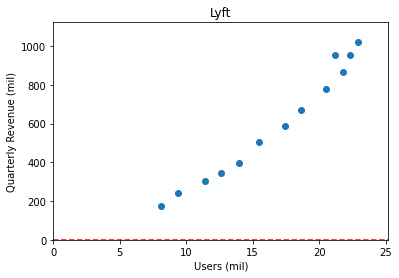

lambda:  0.05
sigma:  -84188.69391951566
kappa:  4086.5066250482923
Netflix
beta0 [ 4.10e+01  1.59e-08 -1.07e-08]
iterations:  300
update_var:  [-1.54792865e+91 -1.34441069e-16  4.09116914e-19]
beta:  [ 3.09585730e+91 -2.30202721e-03  2.56024018e-06]


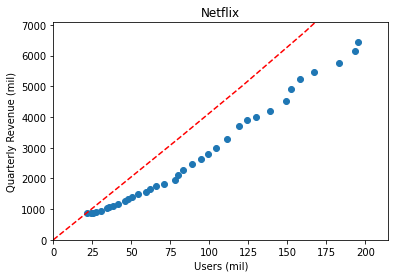

lambda:  41.0
sigma:  -0.0023020272091334735
kappa:  2.5602401800306153e-06
Pinterest
beta0 [ 5.50e-01  2.56e-09 -2.27e-09]
iterations:  300
update_var:  [-2.99969736e+90 -1.34441069e-17 -3.38813179e-21]
beta:  [ 5.99939472e+90  3.11703101e-02 -5.83909763e-05]


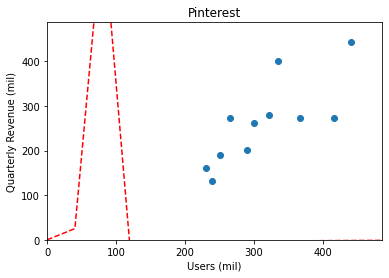

lambda:  0.55
sigma:  0.031170310109776493
kappa:  -5.839097630808142e-05
Ebay
beta0 [2.41e+01 7.87e-09 2.03e-08]
iterations:  300
update_var:  [-1.68220565e+97  1.50433051e-18 -2.01170325e-20]
beta:  [ 3.36441130e+97  4.31977943e+01 -2.28538721e-01]


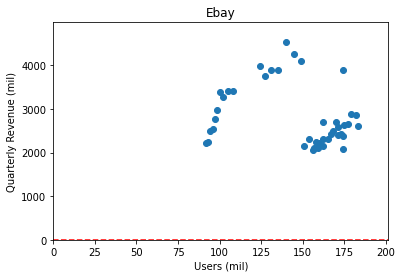

lambda:  24.1
sigma:  43.19779433233227
kappa:  -0.22853872089538507
Match Group
beta0 [2.19e+02 2.09e-07 6.94e-06]
iterations:  300
update_var:  [-6.20718615e+91 -3.13768109e-15  3.67219276e-16]
beta:  [ 1.24143723e+92 -2.49785762e-01  1.10715513e-02]


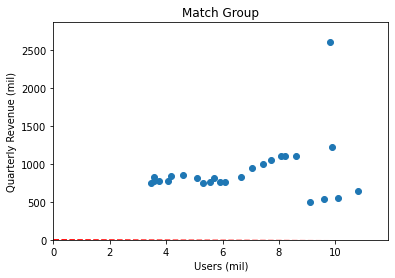

lambda:  219.0
sigma:  -0.24978576212449952
kappa:  0.01107155134548002
Eventbrite
beta0 [ 2.88e+00  3.85e-08 -1.43e-08]
iterations:  300
update_var:  [-2.27736921e+90 -4.53630189e-16  1.53956708e-17]
beta:  [ 4.55473842e+90 -6.89451854e-02  1.48204371e-03]


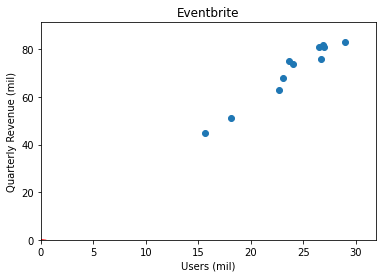

lambda:  2.88
sigma:  -0.06894518542315205
kappa:  0.0014820437118552572


In [10]:
# it looks *okay* for Visa but it's pretty bad for other companies

for company in companies:
    print(company)
    initial_lmda  = list(company_data[company]['revenue_per_user'])[0]
    initial_sigma = list(company_data[company]['gross_margin_density'])[0]
    initial_kappa = list(company_data[company]['gmd_coef'])[0]
    initial_param_values = np.array([initial_lmda, initial_sigma, initial_kappa])

    usl_gradients = np.array([dr_dlambda, dr_dsigma, dr_dkappa])

    users = np.array(company_data[company]['users_mil'])
    rev   = np.array(company_data[company]['quarterly_revenue_mil'])
    
    params = usl_nls_regression(users, rev, initial_param_values, usl_gradients)
    params[0] = initial_param_values[0]
    
    data_model_plot(company, params)

### Nonlinear least-squares regression failed - let's try a mixture model

Text(0, 0.5, 'revenue per user')

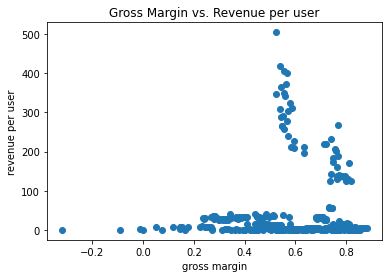

In [11]:
# initial plotting

data = raw_data[['gross_margin', 'revenue_per_user']].copy(deep=True)

# on this line we filter out a couple outlier datapoints so it's
# easier to visualize
data = data.drop(data.loc[data['gross_margin'] < -0.9].index)
plt.scatter(data['gross_margin'], data['revenue_per_user'])
plt.title('Gross Margin vs. Revenue per user')
plt.xlabel('gross margin')
plt.ylabel('revenue per user')

### We'll try Expectation-Maximization
Step 1: Expectation - basically compute the probabilities that each datapoint came from each of your gaussians
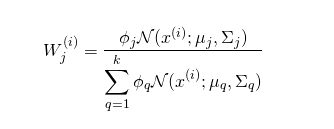
Step 2: Maximization - update weights, means, and covariance matrices using new weights
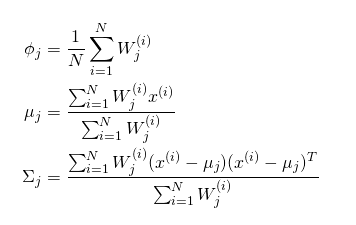


In [12]:
# I wrote these functions for the drug consumption dataset, we'll
# reuse them here.

def initialize_params (num_gaussians, num_vars, mean_init, cov_scale=1):
    # initialize weights randomly
    gauss_weights = np.random.random(num_gaussians)
    gauss_weights /= gauss_weights.sum() # need to add up to 1
    
    # initialize gaussian means randomly between -3 and 3
    r = mean_init*0.5
    gauss_means = np.random.uniform(mean_init - r, mean_init + r, (num_gaussians, num_vars))
    
    # initialize covariance matrices randomly
    # basically: different covariance matrices for each gaussian, initilized as identity matrices
    cov_matrices = np.array([np.eye(num_vars)] * num_gaussians) * cov_scale

    return [gauss_weights, gauss_means, cov_matrices]

In [16]:
# to use a gaussian distribution for our personality traits
from scipy.stats import multivariate_normal

def gaussian_mixture_model (X, num_gaussians):
    '''
    X ~ 
        cols: personalities distributions - we'll use a 1-var gaussian for each one
        rows: entries (N)
    '''
    
    N, num_vars = X.shape
    
    # initialize parameters
    gauss_weights, gauss_means, cov_matrices = initialize_params(num_gaussians, num_vars, X.mean(), X.std())
    
    loglikelihood = 0
    
    max_iterations = 100
    
    for i in range(max_iterations):
        
        # EXPECTATION
        
        E = np.zeros((num_gaussians, N))
        
        for g in range(num_gaussians):
            for s in range(N):
                # try to fit the current data to a distribution
                # to do this we need to get the PDF of our current mean/cov guesses and see P(X)
                E[g, s] = gauss_weights[g] * multivariate_normal(gauss_means[g], cov_matrices[g]).pdf(X[s])
        
        E /= E.sum(0)
        E = np.nan_to_num(E)
        
        # MAXIMIZATION
        
        # update weights, means of each gaussian
        gauss_weights = np.zeros(num_gaussians)
        gauss_means = np.zeros((num_gaussians, num_vars))
        
        for g in range(num_gaussians):
            for s in range(N):
                gauss_weights[g] += E[g, s]
                gauss_means[g] += E[g, s] * X[s]
            gauss_means[g] /= E[g, :].sum()
        
        gauss_weights /= N
        
        # update cov_matrices of each gaussian
        cov_matrices = np.zeros((num_gaussians, num_vars, num_vars))
        for g in range(num_gaussians):
            for s in range(N):
                r = np.reshape(X[s] - gauss_means[g], (num_vars, 1))
                cov_matrices[g] += E[g, s] * np.dot(r, r.T)
            cov_matrices[g] /= E[g, :].sum()
        
        
        # update log likelihood
        loglikelihood_new = 0.0
        for s in range(N):
            l = 0
            for g in range(num_gaussians):
                l += gauss_weights[g] * multivariate_normal(gauss_means[g], cov_matrices[g]).pdf(X[s])
            loglikelihood_new += np.log(l)
            
        # break condition (basically if we're hardly making progress anymore)
        if abs(loglikelihood - loglikelihood_new) < 0.01:
            break
        
        if i % 10 == 0:
            print('iteration ', i)
            print('log(likelihood): ', loglikelihood)

        loglikelihood = loglikelihood_new
    
    return [gauss_weights.round(3), gauss_means.round(3), cov_matrices.round(3)]

In [17]:
# 4 clusters
weights, means, cov_matrices = gaussian_mixture_model(np.array(data), 4)

<ipython-input-16-a71f5ab07983>:32: RuntimeWarning: invalid value encountered in true_divide
  E /= E.sum(0)


iteration  0
log(likelihood):  0
iteration  10
log(likelihood):  -1465.733196140311
iteration  20
log(likelihood):  -1434.5960316716578


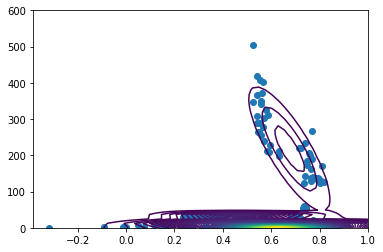

In [18]:
# now let's see if we can somehow show these gaussians on the scatterplot

# contour plotting from here: https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/
X, Y = np.meshgrid(np.linspace(-0.3, 1), np.linspace(0, 600))
XX = np.array([X.ravel(), Y.ravel()]).T

# we need some way to see the probability at each point
# so we'll sum up the PDFs of each gaussian we discovered for each datapoint

def getprob(X, weights, means, cov_matrices):
    p_x = np.zeros(len(X))
    num_gaussians = len(weights)
    for i in range(len(X)):
        for g in range(num_gaussians):
            p_x[i] += weights[g] * multivariate_normal(means[g], cov_matrices[g]).pdf(X[i])
    
    return p_x

Z = getprob(XX, weights, means, cov_matrices)
Z = Z.reshape((50, 50))

plt.contour(X, Y, Z, 200)
plt.scatter(data['gross_margin'], data['revenue_per_user'])
plt.show()

In [19]:
# I generalized this plotting function

def plotcontours(weights, means, covs, num_contours=100):
    X, Y = np.meshgrid(np.linspace(-0.3, 1), np.linspace(0, 600))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = getprob(XX, weights, means, covs)
    Z = Z.reshape((50, 50))
    plt.contour(X, Y, Z, num_contours)
    plt.scatter(data['gross_margin'], data['revenue_per_user'])
    plt.show()    

Text(0, 0.5, 'revenue per user')

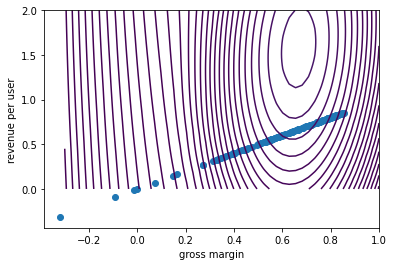

In [20]:
# we can see one of the gaussians appear for companies that have a very high rev/user
# clearly a little chaotic near the low values of revenue/user.
# let's try to filter out companies that have more than ~$2 rev/user
displaydata = data.copy(deep=True)
displaydata['revenue_per_user'] = displaydata.drop(data.loc[data['revenue_per_user'] > 2].index)

X, Y = np.meshgrid(np.linspace(-0.3, 1), np.linspace(0, 2))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = getprob(XX, weights, means, cov_matrices)
Z = Z.reshape((50, 50))

contour_Zs = [10**e for e in np.linspace(-5, 1)]

plt.contour(X, Y, Z, contour_Zs)
plt.scatter(displaydata['gross_margin'], displaydata['revenue_per_user'])
plt.xlabel('gross margin')
plt.ylabel('revenue per user')

In [21]:
# I tried out different numbers of Gaussians
weights2, means2, covs2 = gaussian_mixture_model(np.array(data), 2)
weights3, means3, covs3 = gaussian_mixture_model(np.array(data), 3)
weights5, means5, covs5 = gaussian_mixture_model(np.array(data), 5)

<ipython-input-16-a71f5ab07983>:32: RuntimeWarning: invalid value encountered in true_divide
  E /= E.sum(0)


iteration  0
log(likelihood):  0
iteration  0
log(likelihood):  0
iteration  10
log(likelihood):  -1496.0296938414917
iteration  0
log(likelihood):  0
iteration  10
log(likelihood):  -1400.5179690472078
iteration  20
log(likelihood):  -1357.4382374796887
iteration  30
log(likelihood):  -1348.873209506762
iteration  40
log(likelihood):  -1339.4096108508877
iteration  50
log(likelihood):  -1335.409421384996
iteration  60
log(likelihood):  -1324.882289368155


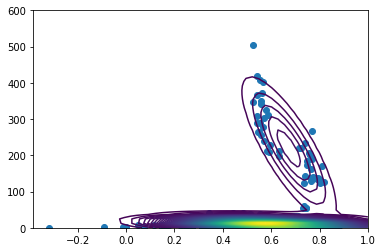

In [22]:
# two gaussians
plotcontours(weights2, means2, covs2, num_contours=150)

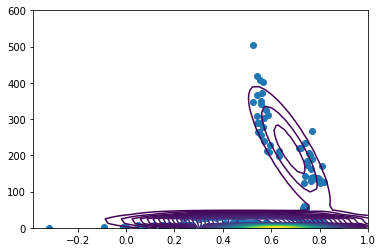

In [23]:
# three gaussians
plotcontours(weights3, means3, covs3, num_contours=170)

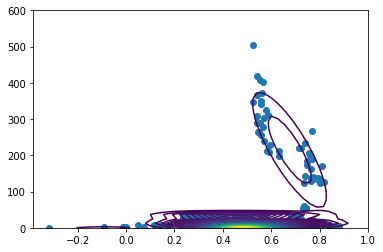

In [24]:
# 5 gaussians
plotcontours(weights5, means5, covs5, num_contours=150)

Text(0, 0.5, 'revenue per user')

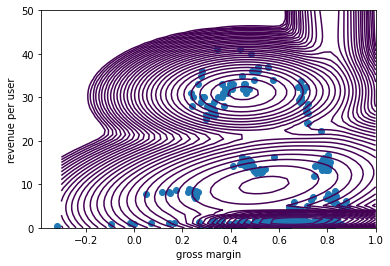

In [25]:
# I guess that one looks a little interesting at the lower rev/user values...
displaydata = data.copy(deep=True)
displaydata = displaydata.drop(data.loc[data['revenue_per_user'] > 50].index)

X, Y = np.meshgrid(np.linspace(-0.3, 1), np.linspace(0, 50))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = getprob(XX, weights, means, cov_matrices)
Z = Z.reshape((50, 50))

contour_Zs = [10**e for e in np.linspace(-5, 1)]

plt.contour(X, Y, Z, contour_Zs)
plt.scatter(displaydata['gross_margin'], displaydata['revenue_per_user'])
plt.xlabel('gross margin')
plt.ylabel('revenue per user')

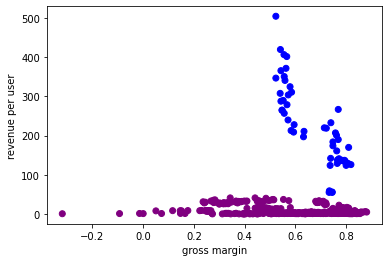

In [27]:
# now we try to classify them and we'll visualize it

# need for color map
import matplotlib.colors as pltcolors

# three looks decent. let's get a closer look and try to classify our datapoints
# using the three gaussians
def plotclassify(weights, means, covs, data):
    classifications = np.zeros((len(data), 1))
    num_gaussians = len(weights)
    for d in range(len(data)):
        max_prob = 0
        for g in range(num_gaussians):
            prob_g = multivariate_normal(means[g], covs[g]).pdf(data[d])
            if prob_g > max_prob:
                max_prob = prob_g
                classifications[d] = g
    
    data = np.append(data, classifications, 1)
    df = pd.DataFrame(data, columns=['gross_margin', 'revenue_per_user', 'class'])
    colors = ['b', 'g', 'r', 'y', 'purple']
    
    plt.scatter(df['gross_margin'], df['revenue_per_user'], c=df['class'], cmap=pltcolors.ListedColormap(colors))
    plt.xlabel('gross margin')
    plt.ylabel('revenue per user')
    

# classification w/ 3 gaussians
plotclassify(weights2, means2, covs2, np.array(data))

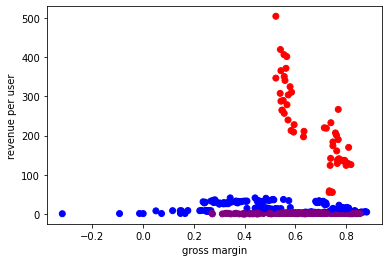

In [28]:
# 3 gaussians
plotclassify(weights3, means3, covs3, np.array(data))

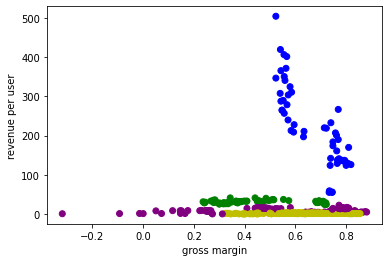

In [29]:
# 4 gaussians
plotclassify(weights, means, cov_matrices, np.array(data))

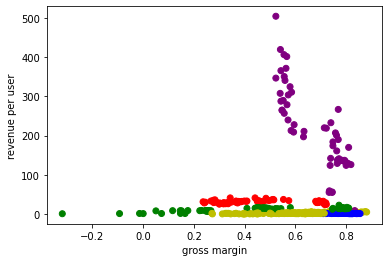

In [30]:
# 5 gaussians
plotclassify(weights5, means5, covs5, np.array(data))

### And that's it. NLS regression unfortunately failed, but I learned a *lot* in attempting it. I'm glad I was able to visualize expectation maximization - that helps a lot. 